In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) # parsing config file
suppressPackageStartupMessages(suppressWarnings(library(lattice))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # grob
suppressPackageStartupMessages(suppressWarnings(library(viridis))) # color
suppressPackageStartupMessages(suppressWarnings(library(platetools))) # make plate plot
suppressPackageStartupMessages(suppressWarnings(library(circlize))) 
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(stringr))) # string manipulation
suppressPackageStartupMessages(suppressWarnings(library(purrr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(VennDiagram))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(tidyverse))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggvenn))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(grid))) # grid
suppressPackageStartupMessages(suppressWarnings(library(Polychrome)))

In [2]:
# set path to all correlations
correlation_path = file.path("..","output","all_plate_channel_correlations.parquet")
figure_path = file.path("..","Figures/")
cor_df <- arrow::read_parquet(correlation_path)
# remove "Corr" from the channel names
cor_df$channel1 <- gsub("Corr", "", cor_df$channel1)
cor_df$channel2 <- gsub("Corr", "", cor_df$channel2)
# replace PM to AGP
cor_df$channel1 <- gsub("PM", "AGP", cor_df$channel1)
cor_df$channel2 <- gsub("PM", "AGP", cor_df$channel2)
cor_df$channel1 <- gsub("Gasdermin", "GSDMD", cor_df$channel1)
cor_df$channel2 <- gsub("Gasdermin", "GSDMD", cor_df$channel2)
# make channel1 a factor
# make a correlation_label column
cor_df$correlation_label <- paste0(cor_df$channel1, "_", cor_df$channel2)
# separate the JUMP and non JUMP correlations
jump_cor_df <- cor_df %>% filter(grepl("BR00", plate))
non_jump_cor_df <- cor_df %>% filter(!grepl("BR00", plate))
jump_cor_df$channel1 <- factor(jump_cor_df$channel1, levels = c("AGP", "DNA", "ER", "Mito", "RNA" ))
jump_cor_df$channel2 <- factor(jump_cor_df$channel2, levels = c("AGP", "DNA", "ER", "Mito", "RNA"))
non_jump_cor_df$channel1 <- factor(non_jump_cor_df$channel1, levels = c("AGP", "DNA", "ER", "Mito", "GSDMD"))
non_jump_cor_df$channel2 <- factor(non_jump_cor_df$channel2, levels = c("AGP", "DNA", "ER", "Mito", "GSDMD"))
# remove self correlations
head(jump_cor_df)

channel1,channel2,correlation,plate,well,correlation_label
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>
ER,Mito,0.7198829,BR00117004_normalized_sc_agg,A01,ER_Mito
ER,DNA,0.5179363,BR00117004_normalized_sc_agg,A01,ER_DNA
ER,AGP,0.9162101,BR00117004_normalized_sc_agg,A01,ER_AGP
ER,RNA,0.9632002,BR00117004_normalized_sc_agg,A01,ER_RNA
Mito,ER,0.7198829,BR00117004_normalized_sc_agg,A01,Mito_ER
Mito,DNA,0.1735317,BR00117004_normalized_sc_agg,A01,Mito_DNA


In [3]:
# set custome color palette
my_palette <- c("AGP" = "red", "DNA" = "blue", "ER" = "dark green", "Mito" = "purple", "RNA" = "orange", "GSDMD" = "yellow")

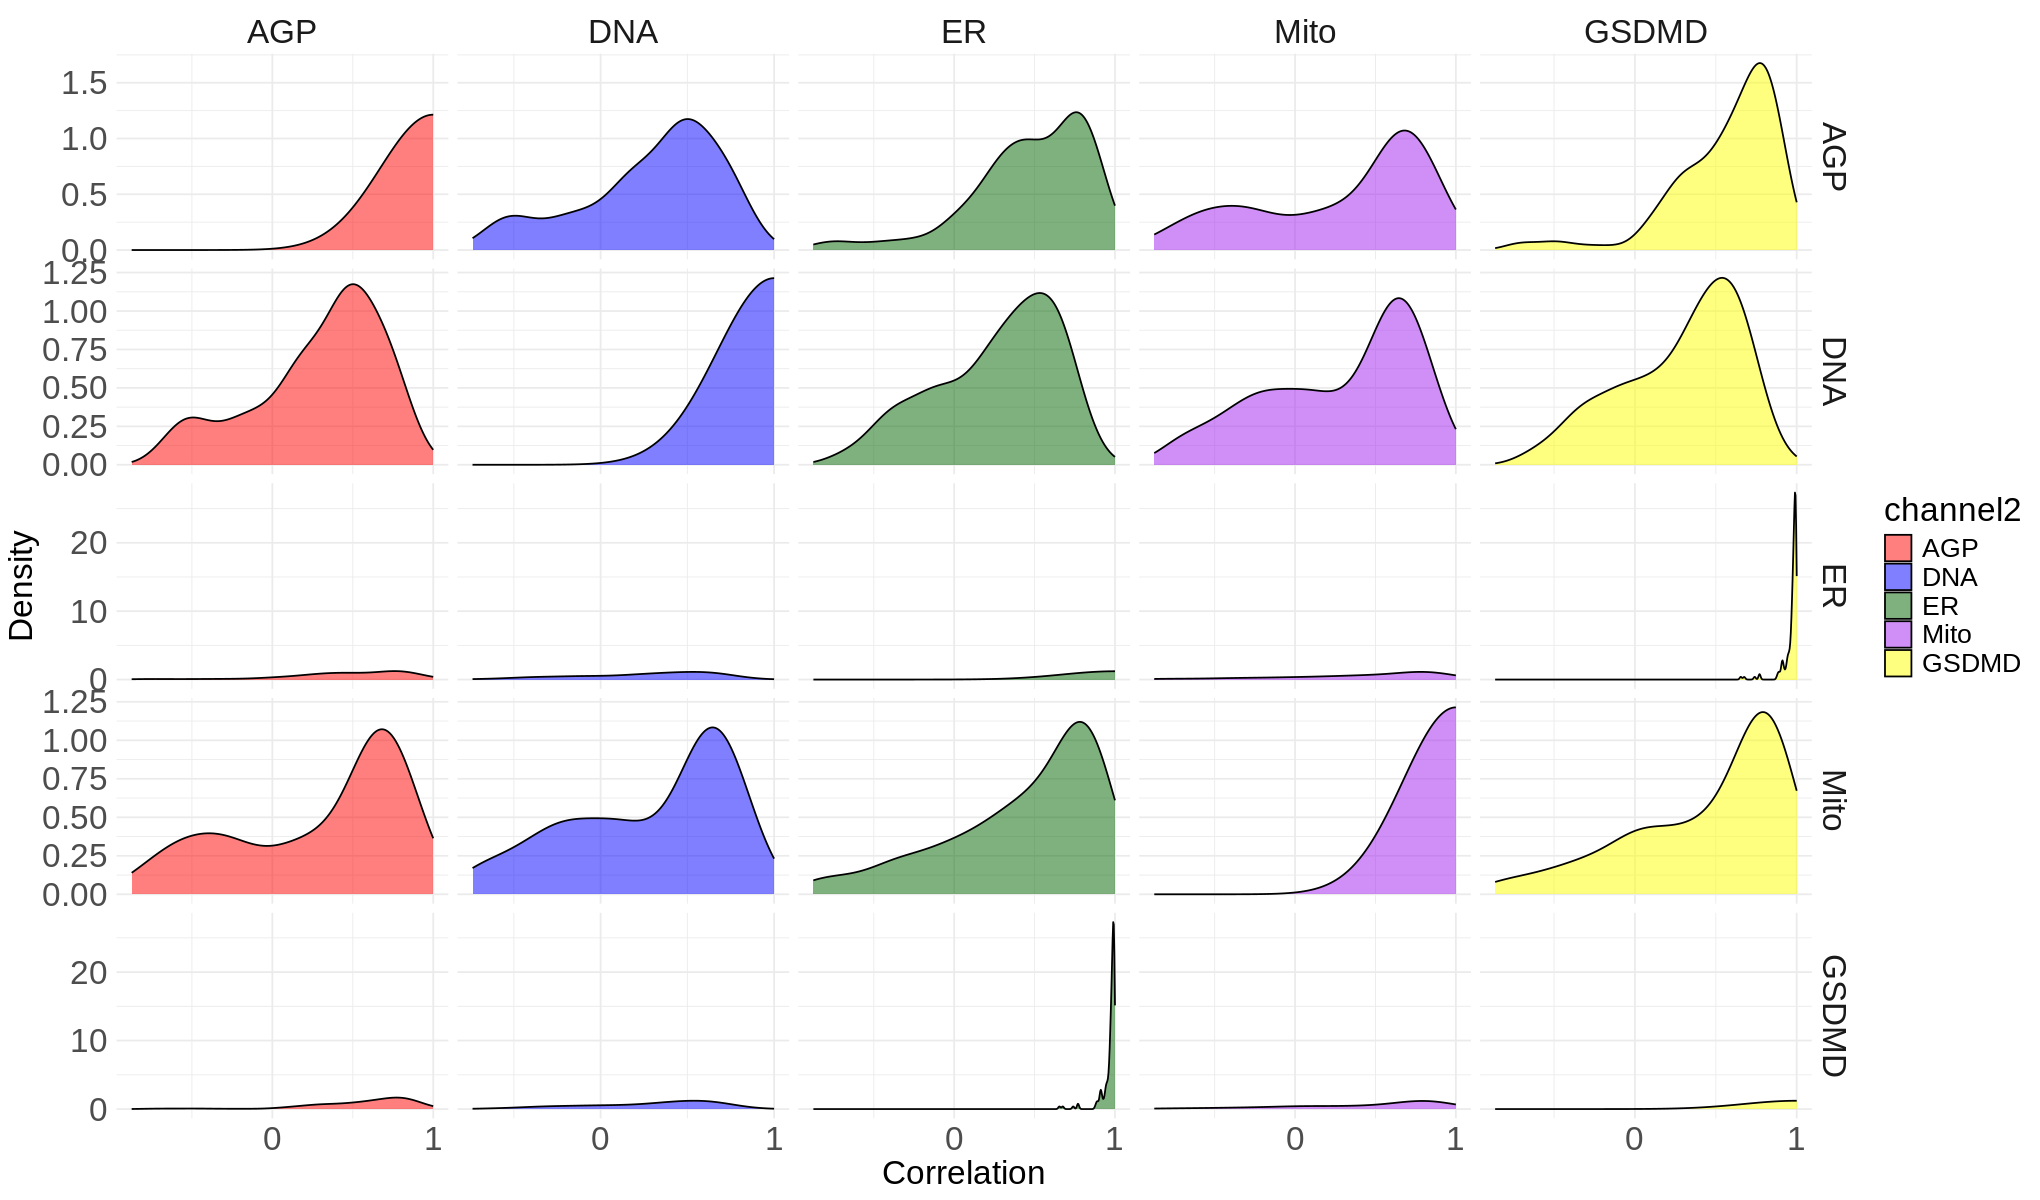

In [4]:
width <- 17
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

density_plot <- (
    ggplot(non_jump_cor_df, aes(x=correlation, fill = channel2)) 
    + geom_density(alpha = 0.5)
    + theme_minimal()
    + xlab("Correlation")
    + ylab("Density")
    # show only the top triangle of the grid
    + facet_grid(channel1 ~ channel2, scales = "free",drop = TRUE)
    # change x axis ticks
    + scale_x_continuous(breaks = seq(0,1,1))
    # increase font sizes
    + theme(
        text = element_text(size=20),
        axis.text.x = element_text(size=20),
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size=20),
        axis.title.y = element_text(size=20),
        strip.text = element_text(size=20)
    )
    # apply custom color palette
    + scale_fill_manual(values = my_palette)
)
density_plot
ggsave(file = file.path(paste0(figure_path, "density_plot_channel_correlations.png")), plot = density_plot, width = width, height = height)

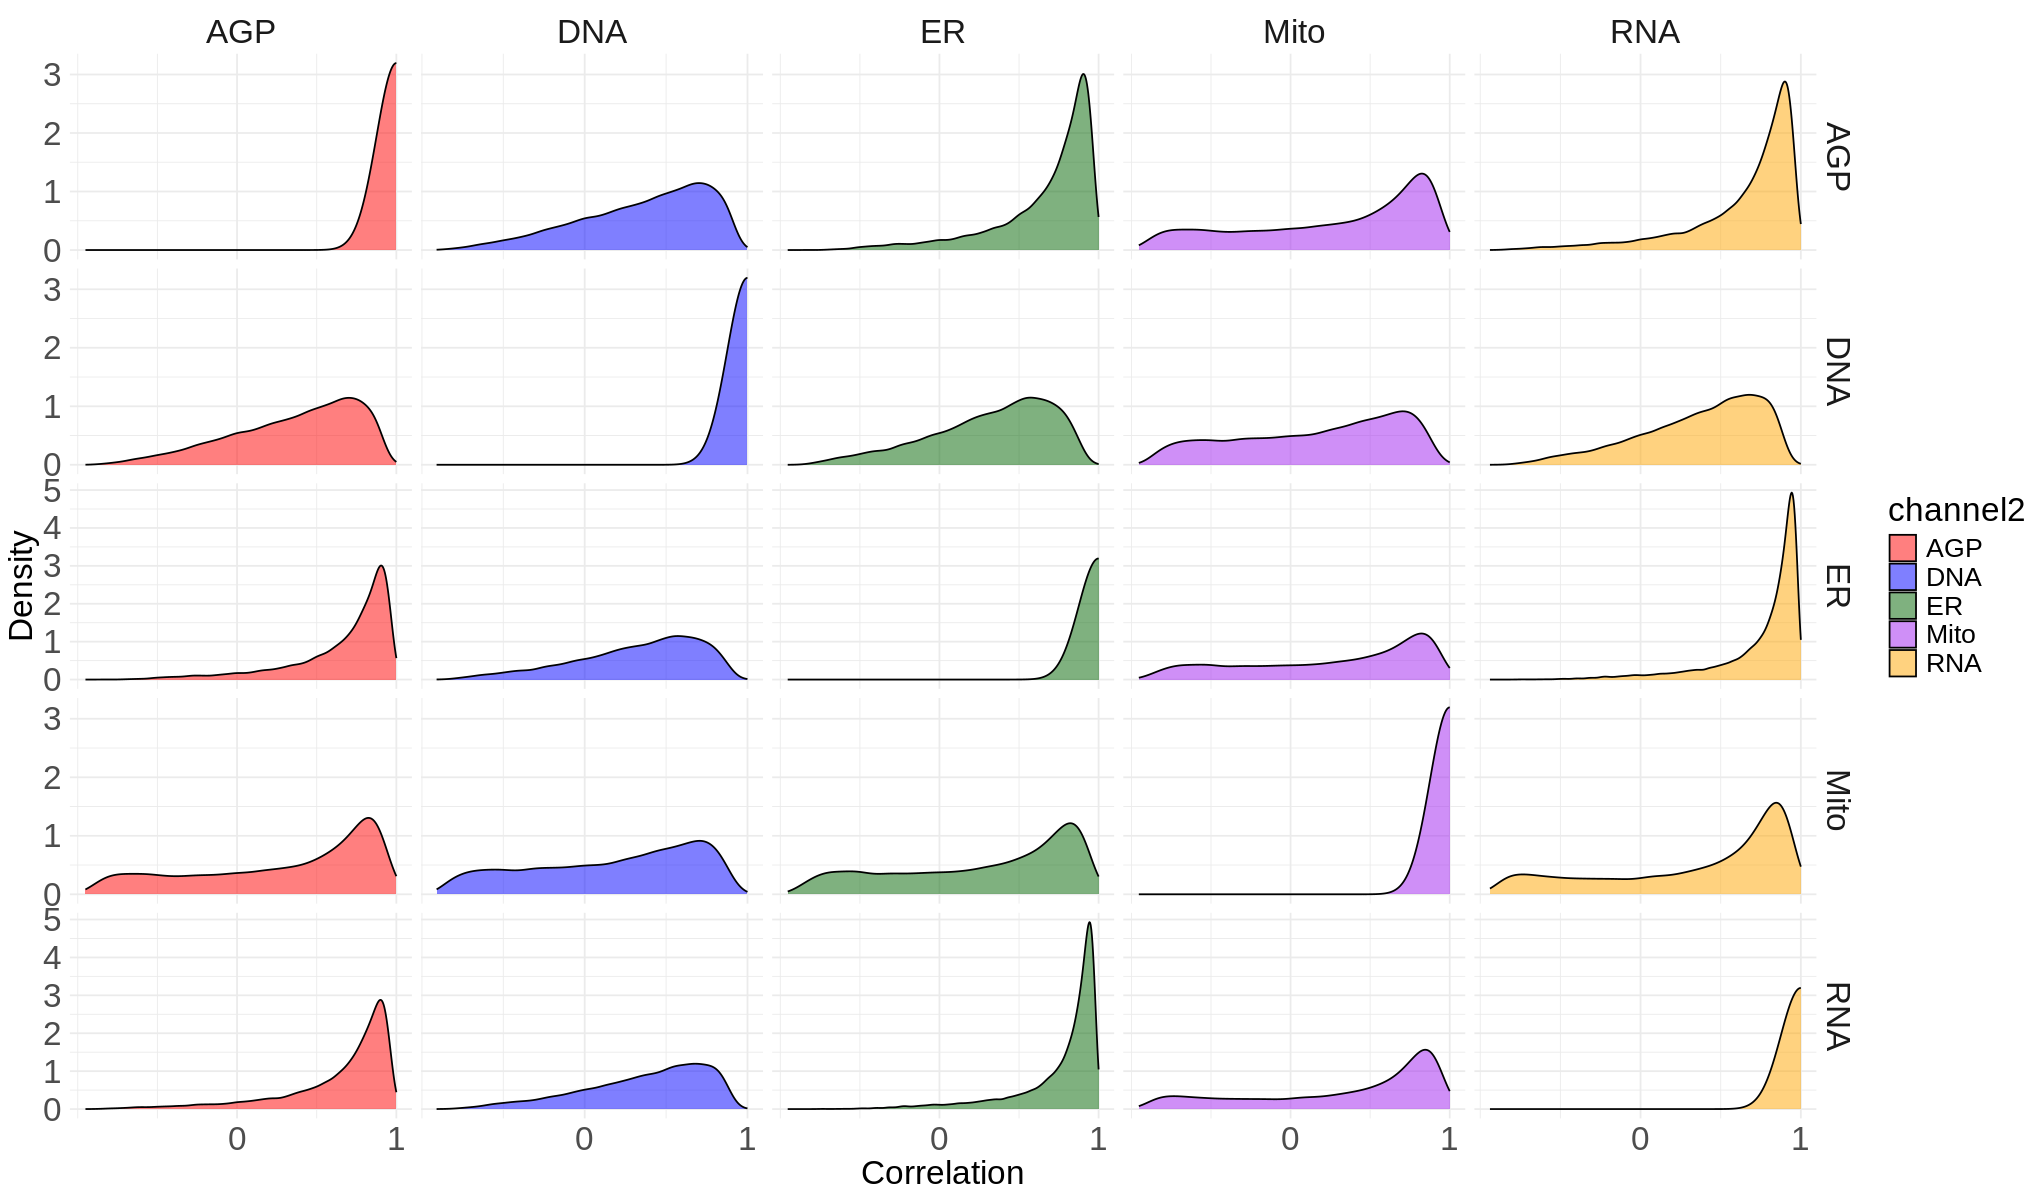

In [5]:
width <- 17
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

jump_density_plot <- (
    ggplot(jump_cor_df, aes(x=correlation, fill = channel2)) 
    + geom_density(alpha = 0.5)
    + theme_minimal()
    + xlab("Correlation")
    + ylab("Density")
    + facet_grid(channel1 ~ channel2, scales = "free",drop = TRUE)
    # change x axis ticks
    + scale_x_continuous(breaks = seq(0,1,1))
    # increase font sizes
    + theme(
        text = element_text(size=20),
        axis.text.x = element_text(size=20),
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size=20),
        axis.title.y = element_text(size=20),
        strip.text = element_text(size=20)
    )
    # apply custom color palette
    + scale_fill_manual(values = my_palette)
)
jump_density_plot
ggsave(file = file.path(paste0(figure_path, "JUMP_one_plate_density_plot_channel_correlations.png")), plot = jump_density_plot, width = width, height = height)

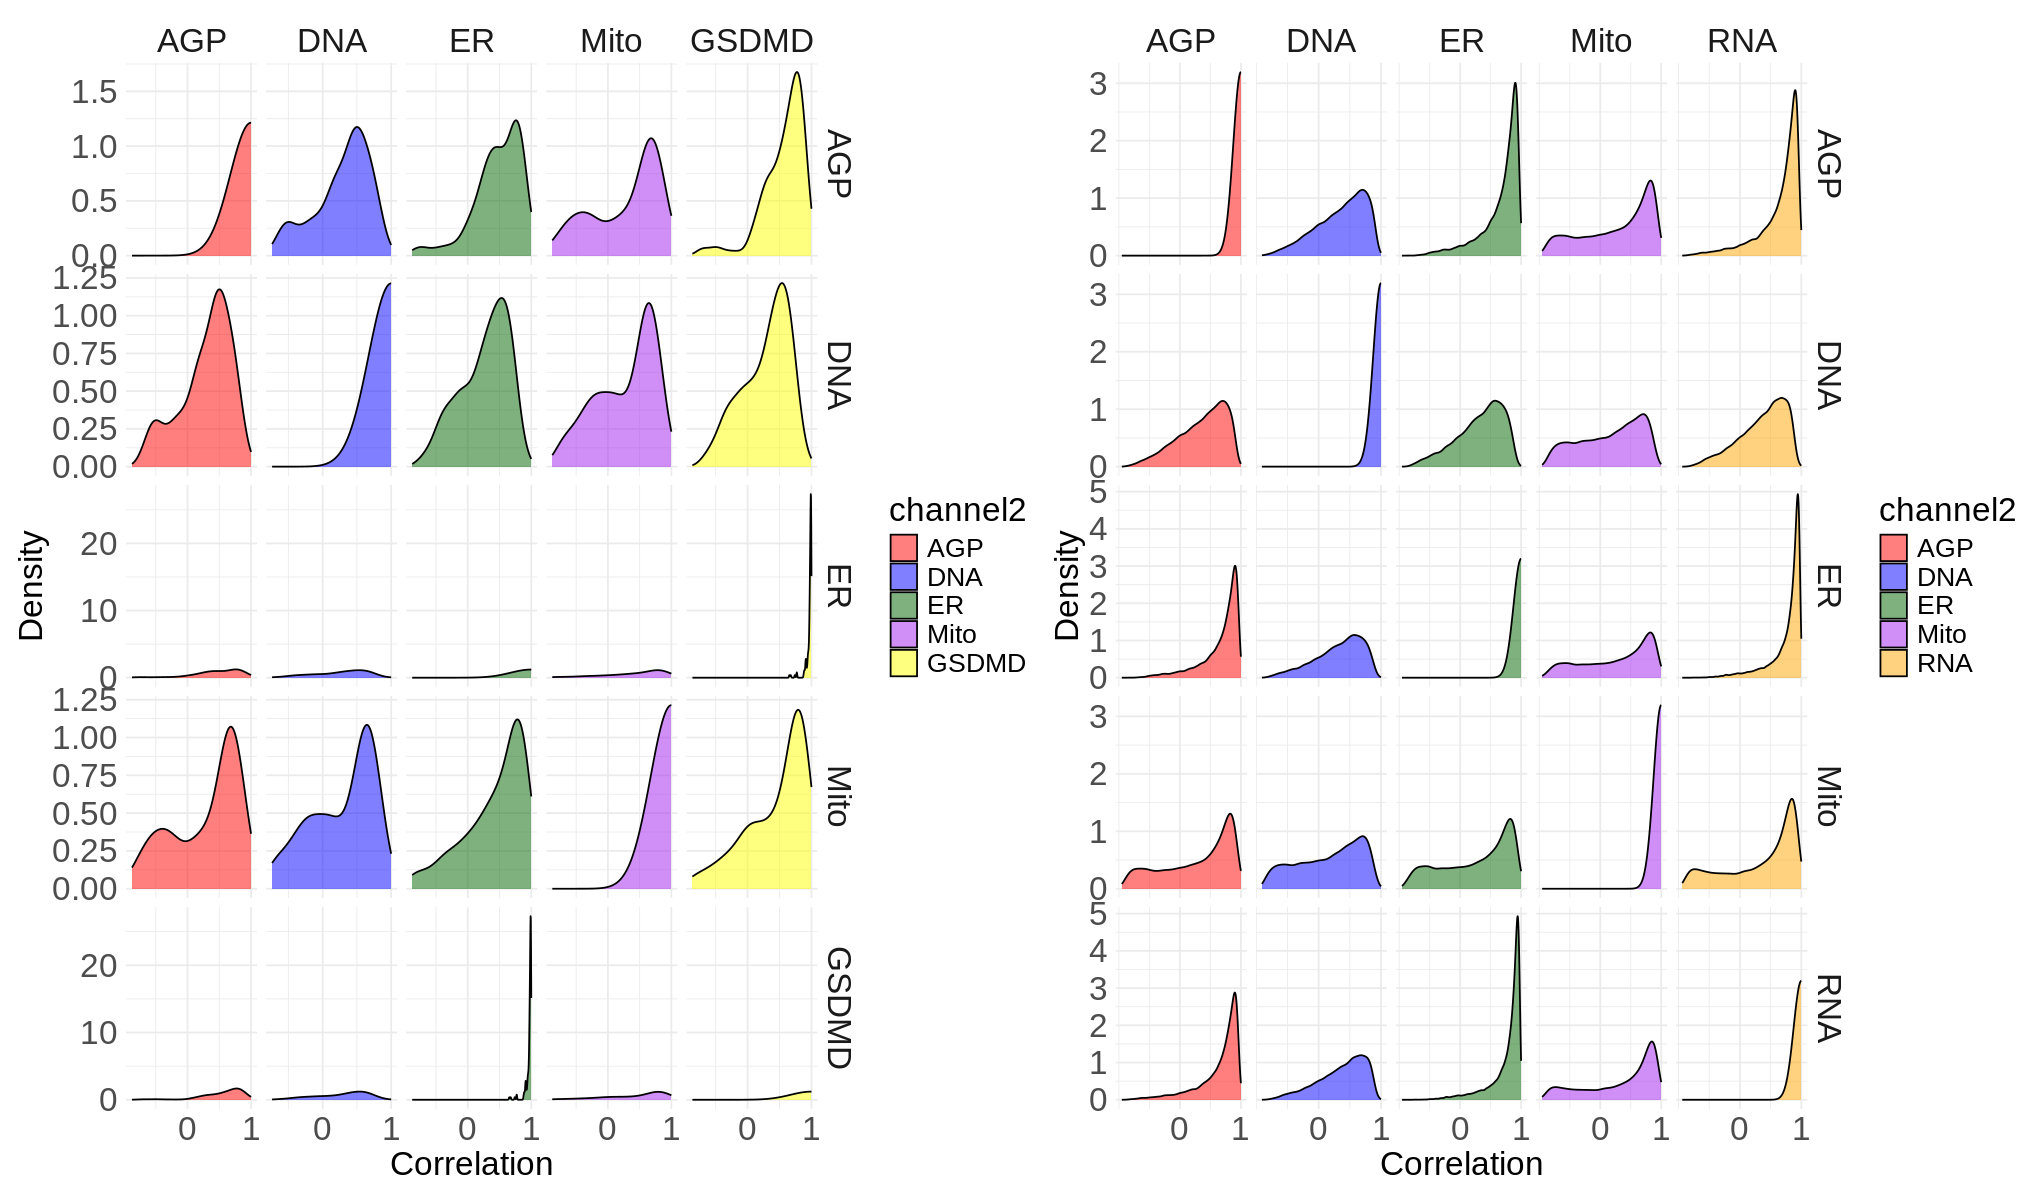

In [6]:
width <- 17
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

# patch the plots together
final_plot <- (density_plot + jump_density_plot)
# save the plot
ggsave(file = file.path(paste0(figure_path, "both_density_plot_channel_correlations.png")), plot = final_plot, width = width, height = height)
final_plot